In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from gnn import gnn
import torch.nn as nn
import torch
from torch.utils.data import DataLoader                                     
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os, argparse, time, shutil, sys, random, datetime
import utils
from rdkit import Chem
from rdkit.Chem import QED
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
class Params: pass

g = Params()
g.num_epochs = 1000
g.lr = 0.0001
g.batch_size = 64
g.n_graph_layer = 4
g.d_graph_layer = 140
g.n_FC_layer = 4
g.d_FC_layer = 128
g.initial_mu = 4.46108546619827
g.initial_dev = 0.19818493842903845
g.dropout_rate = 0.3
g.data_fpath = 'cbidata'
g.save_dir = 'save'
g.random_stratify = True
g.cache_dir = '/tmp/moldata'
g.clear_cache = False
g.train_keys = 'keys/keys_refined'
g.kinase_list = 'keys/kinase_list'
g.dataset_version = 2
g.cpu_count = 10

In [4]:
def get_kinase_set():
    kinase = set()
    for line in open('keys/kinase_list', 'rt'):
        line = line.strip()
        kinase.add(line)
    return kinase

In [5]:
def read_keyfile(fname, local=False):
    keys = []
    for line in open(fname):
        line = line.rstrip()
        if line.startswith('#'):
            continue
        it = line.split('\t')
        if local:
            pdb_code, value = it[0], float(it[1])
        else:
            pdb_code, ligand_name, year, value = it[0], it[1], int(it[2]), float(it[3])
        if os.path.exists(f'cbidata/{pdb_code}'):
            keys.append((pdb_code, value))
    return keys

In [6]:
def read_ligand(dirname):
    sdf_found = False
    for f in os.listdir(dirname):
        if f.endswith('.sdf'):
            sdf_found = True
            sdf_fname = f'{dirname}/{f}'
            for ligand_mol in Chem.SDMolSupplier(sdf_fname):
                break
            break
    return ligand_mol if sdf_found else None

In [7]:
def filter_and_stratify(*dataset, random_stratify=False):
    kinase = get_kinase_set()
    all_data = []
    for _ in dataset:
        all_data += _
    if random_stratify:
        random.shuffle(all_data)
    else:
        data = sorted(all_data, key=lambda x: x[1], reverse=True)
    train = []
    test = []
    test2 = []

    count = 0
    for key, pkd in all_data:
        if key not in kinase:
            continue

        if pkd < 2 or 11 < pkd:
            test2.append((key, pkd))
            continue

        ligand_mol = read_ligand(f'cbidata/{key}')

        n_atoms = ligand_mol.GetNumAtoms()
        if n_atoms < 10 or 45 < n_atoms:
            test2.append((key, pkd))
            continue
        if QED.qed(ligand_mol) < 0.4:
            test2.append((key, pkd))
            continue

        count += 1

        if count % 5 == 0:
            test.append((key, pkd))
        else:
            train.append((key, pkd))
    return train, test, test2

In [8]:
def write_keys(keys, oname):
    with open(oname, 'wt') as out:
        for key, pkd in keys:
            print(key, pkd, sep='\t', file=out)

In [9]:
datetime.datetime.now().isoformat()

'2020-09-01T22:45:10.832925'

In [10]:
assert g.dataset_version in [1, 2]
if g.dataset_version == 1:
    import dataset as ds
else:
    import dataset2 as ds

In [11]:
if g.clear_cache:
    try:
        shutil.rmtree(g.cache_dir)
    except:
        pass

In [12]:
os.makedirs(g.save_dir, exist_ok=True)
data = read_keyfile(g.train_keys)
train_keys, test_keys, test2_keys = filter_and_stratify(data, random_stratify=g.random_stratify)
write_keys(train_keys, 'train.local.key')
write_keys(test_keys, 'test.local.key')
write_keys(test2_keys, 'test2.local.key')
len(train_keys), len(test_keys), len(test2_keys)

(202, 50, 75)

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [14]:
train_dataset = ds.MolDataset([k for k, v in train_keys], [v for k, v in train_keys], g.data_fpath)
test_dataset = ds.MolDataset([k for k, v in train_keys], [v for k, v in test_keys], g.data_fpath)
len(train_dataset), len(test_dataset)

(202, 50)

In [15]:
n_atom_features = train_dataset[0]['H'].shape[1]//2
g.N_atom_features = n_atom_features
n_atom_features

21

In [16]:
train_dataloader = DataLoader(train_dataset, g.batch_size, shuffle=True, num_workers=g.cpu_count, collate_fn=ds.collate_fn)
test_dataloader = DataLoader(test_dataset, g.batch_size, shuffle=True, num_workers=g.cpu_count, collate_fn=ds.collate_fn)

In [17]:
model = utils.initialize_model(gnn(g), device)
model

gnn(
  (gconv1): ModuleList(
    (0): GAT_gate(
      (W): Linear(in_features=140, out_features=140, bias=True)
      (gate): Linear(in_features=280, out_features=1, bias=True)
      (leakyrelu): LeakyReLU(negative_slope=0.2)
    )
    (1): GAT_gate(
      (W): Linear(in_features=140, out_features=140, bias=True)
      (gate): Linear(in_features=280, out_features=1, bias=True)
      (leakyrelu): LeakyReLU(negative_slope=0.2)
    )
    (2): GAT_gate(
      (W): Linear(in_features=140, out_features=140, bias=True)
      (gate): Linear(in_features=280, out_features=1, bias=True)
      (leakyrelu): LeakyReLU(negative_slope=0.2)
    )
    (3): GAT_gate(
      (W): Linear(in_features=140, out_features=140, bias=True)
      (gate): Linear(in_features=280, out_features=1, bias=True)
      (leakyrelu): LeakyReLU(negative_slope=0.2)
    )
  )
  (FC): ModuleList(
    (0): Linear(in_features=140, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Li

In [18]:
print ('number of parameters : ', sum(p.numel() for p in model.parameters() if p.requires_grad))

number of parameters :  215567


In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=g.lr)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

In [20]:
loss_fn = nn.MSELoss()
loss_fn

MSELoss()

In [21]:
def learn(model, loader, train=True):
    losses = []
    for sample in loader:
        model.zero_grad()
        H, A1, A2, Y, V, keys, _ = sample 
        H, A1, A2, Y, V = H.to(device), A1.to(device), A2.to(device), Y.to(device), V.to(device)

        pred = model.train_model((H, A1, A2, V))

        loss = loss_fn(pred, Y)
        if train:
            loss.backward()
            optimizer.step()
        losses.append(loss.data.cpu().numpy())
    mean_loss = np.mean(np.array(losses))
    return mean_loss

In [22]:
def myplot(y_obs, y_pred, Los, Lps):
    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    xs = list(range(len(Los)))
    ax1.plot(xs, Los)
    ax1.plot(xs, Lps)
    if min(Los) < 10 and min(Lps) < 10:
        _ymax = 15
    else:
        _ymax = 60
    ax1.set_ylim(0, _ymax)
    ax2.scatter(y_obs, y_pred)
    ax2.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    ax2.set_xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    ax2.set_ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    ax2.set_xlabel('Experimental', fontsize=16)
    ax2.set_ylabel('Calculated', fontsize=16)
    ax2.tick_params(labelsize=16)
    plt.subplots_adjust(wspace=.5)
    plt.show()

In [23]:
def test(model, loader):
    test_true, test_pred, test_label = [], [], []

    saliency_list = []
    n_atom_list = []

    model.eval()
    for i_batch, sample in enumerate(loader):
        model.zero_grad()
        H, A1, A2, Y, V, keys, n_atom = sample

        embed = model.embede(H)
        model.zero_grad()
        pred = model.test_model((embed, A1, A2, V))

        out = torch.sum(pred)
        embed.retain_grad()
        out.backward()
        saliency = embed.grad.clone()
        saliency *= embed.data.clone()

        test_true.append(Y.data.cpu().numpy())
        test_pred.append(pred.data.cpu().numpy())
        test_label.append(keys)
        saliency_list.append(saliency)
        n_atom_list.append(n_atom)

    test_pred = np.concatenate(np.array(test_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    return test_true, test_pred, test_label, saliency_list, n_atom_list

In [24]:
def get_stats(X, y):
    rmse = mean_squared_error(X, y)**0.5
    mae = mean_absolute_error(X, y)
    r2 = stats.pearsonr(X, y)
    rho = stats.spearmanr(X, y)
    return rmse, mae, r2[0], rho[0]

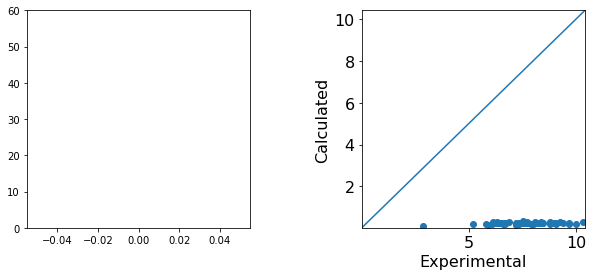

rmse: 7.462, mae: 7.339, r2: 0.396, rho: 0.253
Epoch: 0	Lapse: 3.7s	Losses: (48.692, 55.687)	Best: (48.692, 55.687)


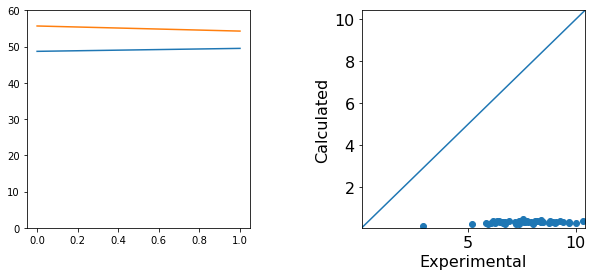

rmse: 7.367, mae: 7.244, r2: 0.405, rho: 0.264
Epoch: 1	Lapse: 4.6s	Losses: (49.509, 54.279)	Best: (48.692, 54.279)


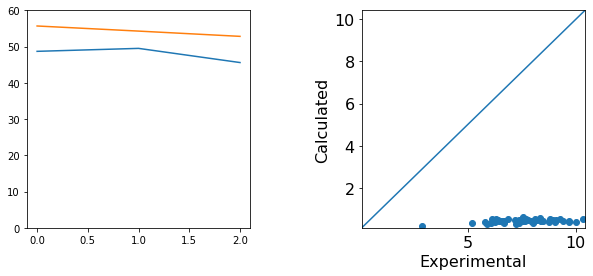

rmse: 7.268, mae: 7.145, r2: 0.404, rho: 0.265
Epoch: 2	Lapse: 4.8s	Losses: (45.600, 52.827)	Best: (45.600, 52.827)


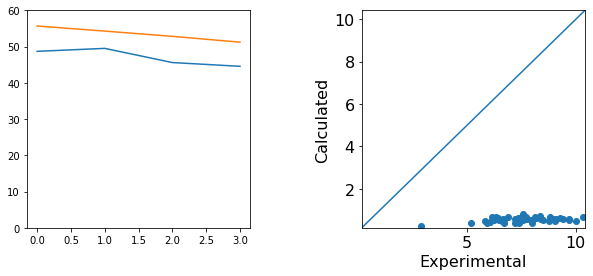

rmse: 7.157, mae: 7.033, r2: 0.398, rho: 0.267
Epoch: 3	Lapse: 5.1s	Losses: (44.562, 51.221)	Best: (44.562, 51.221)


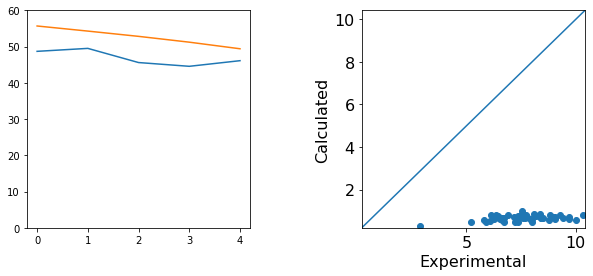

rmse: 7.029, mae: 6.904, r2: 0.404, rho: 0.268
Epoch: 4	Lapse: 5.1s	Losses: (46.114, 49.403)	Best: (44.562, 49.403)


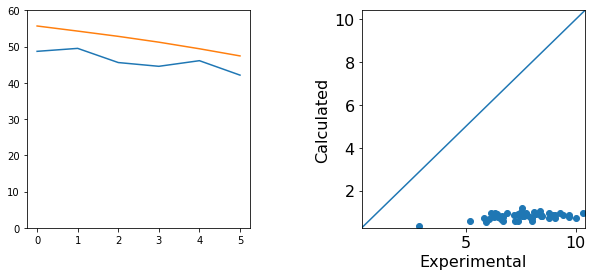

rmse: 6.887, mae: 6.761, r2: 0.412, rho: 0.272
Epoch: 5	Lapse: 5.2s	Losses: (42.128, 47.429)	Best: (42.128, 47.429)


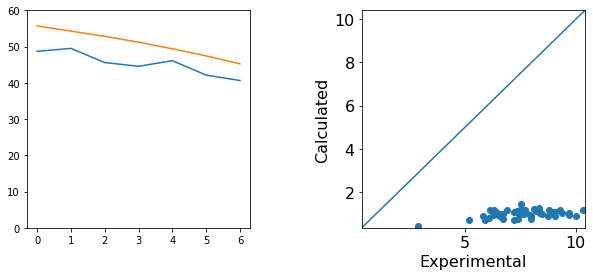

rmse: 6.726, mae: 6.600, r2: 0.418, rho: 0.271
Epoch: 6	Lapse: 5.0s	Losses: (40.640, 45.246)	Best: (40.640, 45.246)


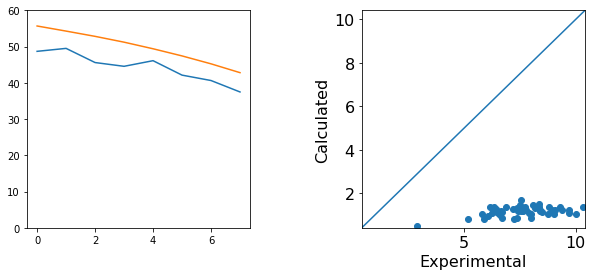

rmse: 6.543, mae: 6.414, r2: 0.420, rho: 0.281
Epoch: 7	Lapse: 5.0s	Losses: (37.482, 42.809)	Best: (37.482, 42.809)


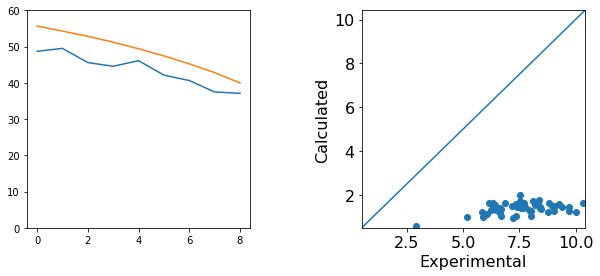

rmse: 6.323, mae: 6.192, r2: 0.421, rho: 0.278
Epoch: 8	Lapse: 4.9s	Losses: (37.109, 39.979)	Best: (37.109, 39.979)


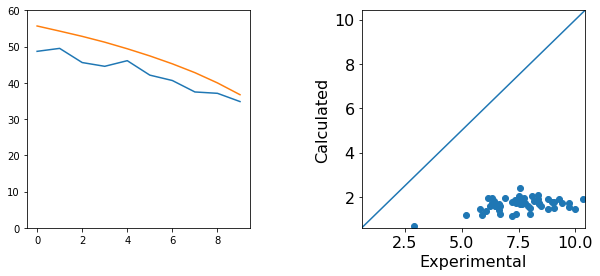

rmse: 6.060, mae: 5.926, r2: 0.424, rho: 0.277
Epoch: 9	Lapse: 5.1s	Losses: (34.833, 36.726)	Best: (34.833, 36.726)


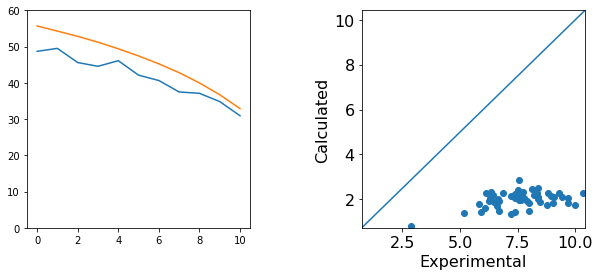

rmse: 5.735, mae: 5.596, r2: 0.424, rho: 0.266
Epoch: 10	Lapse: 5.0s	Losses: (30.921, 32.894)	Best: (30.921, 32.894)


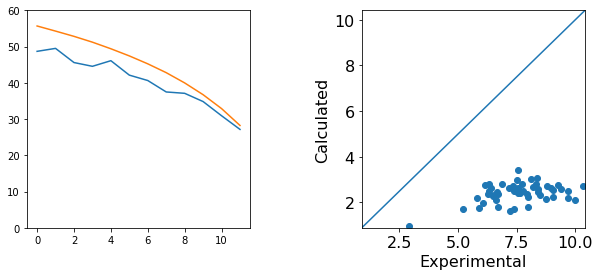

rmse: 5.314, mae: 5.166, r2: 0.424, rho: 0.264
Epoch: 11	Lapse: 5.4s	Losses: (27.149, 28.238)	Best: (27.149, 28.238)


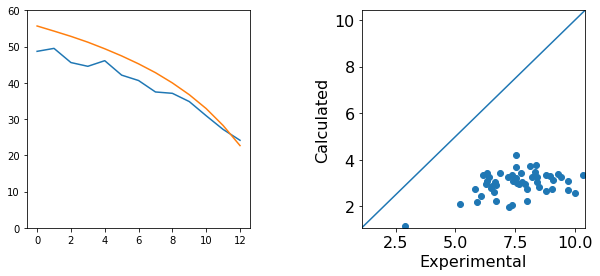

rmse: 4.763, mae: 4.600, r2: 0.427, rho: 0.259
Epoch: 12	Lapse: 5.1s	Losses: (24.151, 22.684)	Best: (24.151, 22.684)


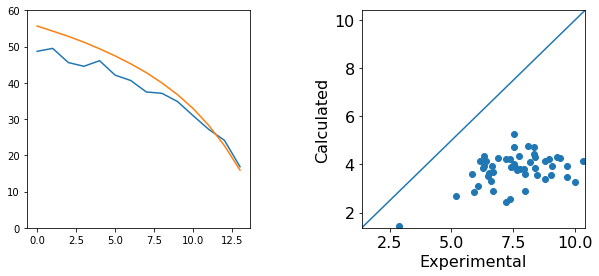

rmse: 3.987, mae: 3.792, r2: 0.433, rho: 0.279
Epoch: 13	Lapse: 4.7s	Losses: (16.855, 15.899)	Best: (16.855, 15.899)


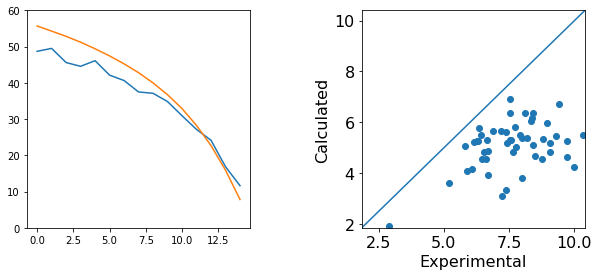

rmse: 2.794, mae: 2.487, r2: 0.436, rho: 0.288
Epoch: 14	Lapse: 4.7s	Losses: (11.620, 7.806)	Best: (11.620, 7.806)


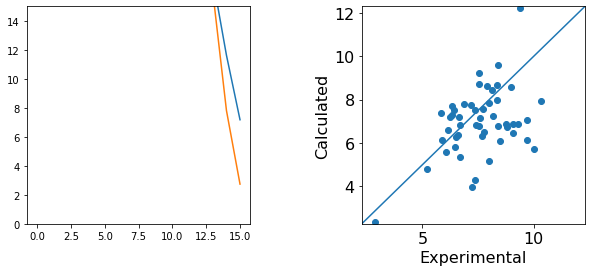

rmse: 1.655, mae: 1.290, r2: 0.435, rho: 0.263
Epoch: 15	Lapse: 5.1s	Losses: (7.179, 2.739)	Best: (7.179, 2.739)


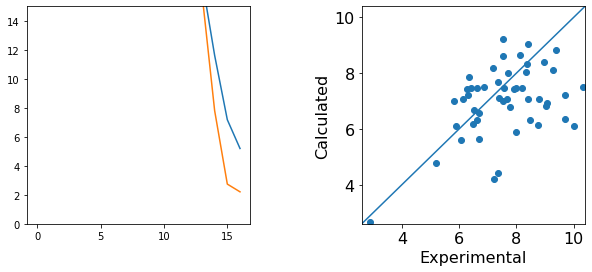

rmse: 1.485, mae: 1.136, r2: 0.451, rho: 0.290
Epoch: 16	Lapse: 4.6s	Losses: (5.196, 2.205)	Best: (5.196, 2.205)
Epoch: 17	Lapse: 5.0s	Losses: (4.723, 2.475)	Best: (4.723, 2.205)
Epoch: 18	Lapse: 5.1s	Losses: (4.484, 2.736)	Best: (4.484, 2.205)
Epoch: 19	Lapse: 5.5s	Losses: (4.457, 3.066)	Best: (4.457, 2.205)
Epoch: 20	Lapse: 5.5s	Losses: (4.593, 3.304)	Best: (4.457, 2.205)
Epoch: 21	Lapse: 5.0s	Losses: (4.945, 3.044)	Best: (4.457, 2.205)
Epoch: 22	Lapse: 4.9s	Losses: (5.175, 2.670)	Best: (4.457, 2.205)
Epoch: 23	Lapse: 4.9s	Losses: (4.881, 2.420)	Best: (4.457, 2.205)


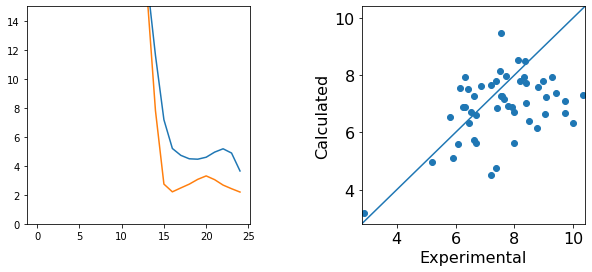

rmse: 1.480, mae: 1.159, r2: 0.454, rho: 0.317
Epoch: 24	Lapse: 5.0s	Losses: (3.644, 2.190)	Best: (3.644, 2.190)
Epoch: 25	Lapse: 5.0s	Losses: (3.610, 2.199)	Best: (3.610, 2.190)
Epoch: 26	Lapse: 5.0s	Losses: (5.236, 2.418)	Best: (3.610, 2.190)
Epoch: 27	Lapse: 5.4s	Losses: (3.748, 2.375)	Best: (3.610, 2.190)


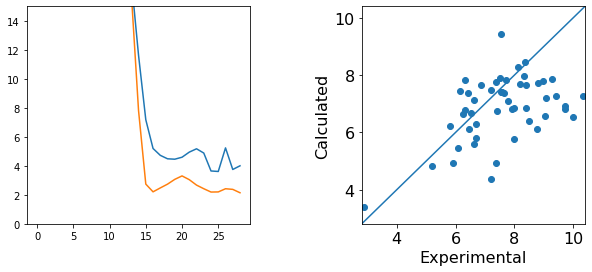

rmse: 1.463, mae: 1.134, r2: 0.485, rho: 0.354
Epoch: 28	Lapse: 5.1s	Losses: (4.001, 2.142)	Best: (3.610, 2.142)


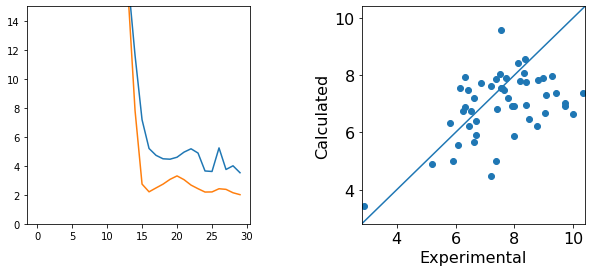

rmse: 1.418, mae: 1.102, r2: 0.487, rho: 0.361
Epoch: 29	Lapse: 5.0s	Losses: (3.523, 2.010)	Best: (3.523, 2.010)
Epoch: 30	Lapse: 4.7s	Losses: (4.187, 2.192)	Best: (3.523, 2.010)
Epoch: 31	Lapse: 5.0s	Losses: (3.430, 2.227)	Best: (3.430, 2.010)
Epoch: 32	Lapse: 5.0s	Losses: (4.100, 2.379)	Best: (3.430, 2.010)
Epoch: 33	Lapse: 5.2s	Losses: (4.708, 2.423)	Best: (3.430, 2.010)
Epoch: 34	Lapse: 5.0s	Losses: (4.814, 2.058)	Best: (3.430, 2.010)


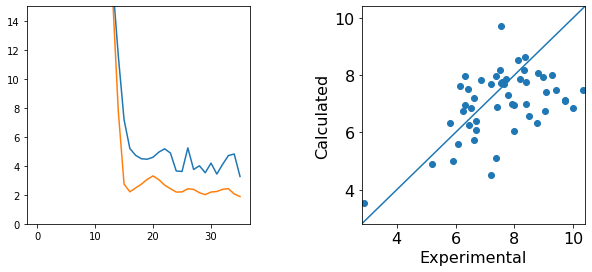

rmse: 1.372, mae: 1.079, r2: 0.502, rho: 0.383
Epoch: 35	Lapse: 5.1s	Losses: (3.267, 1.883)	Best: (3.267, 1.883)
Epoch: 36	Lapse: 4.9s	Losses: (3.525, 2.025)	Best: (3.267, 1.883)
Epoch: 37	Lapse: 5.1s	Losses: (3.962, 2.576)	Best: (3.267, 1.883)


In [ ]:
CLEAR_OUTPUT_WHEN_UPDATE = False

best_train_loss, best_val_loss = np.inf, np.inf
Los = []
Lps = []

for epoch in range(g.num_epochs):
    st = time.time()
    train_losses, test_losses = [], []

    model.train()
    train_loss = learn(model, train_dataloader)
    Los.append(train_loss)

    model.eval()
    test_loss = learn(model, test_dataloader, train=False)
    Lps.append(test_loss)

    lapse = time.time() - st

    if train_loss < best_train_loss:
        best_train_loss = train_loss

    output = False
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        torch.save(model.state_dict(), f'{g.save_dir}/save_{epoch}.pt')
        torch.save(model.state_dict(), f'{g.save_dir}/model_weights.pt')
        output = True

    if output:
        X, y, L, S, N = test(model, test_dataloader)
        df = pd.DataFrame(dict(PDB=L[0], pKd=X, predicted=y, error=np.abs(X-y)))
        df.to_csv(f'results_{epoch}.tsv', sep='\t')

        rmse, mae, r2, rho = get_stats(X, y)
        if CLEAR_OUTPUT_WHEN_UPDATE:
            clear_output()
        myplot(X, y, Los, Lps)
        print(f'rmse: {rmse:5.3f}, mae: {mae:5.3f}, r2: {r2:5.3f}, rho: {rho:5.3f}')

    ls = [f'Epoch: {epoch}',
          f'Lapse: {lapse:.1f}s',
          f'Losses: ({train_loss:.3f}, {test_loss:.3f})',
          f'Best: ({best_train_loss:.3f}, {best_val_loss:.3f})']
    print('\t'.join(ls))